In [ ]:
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil
from os import listdir
from os.path import isfile, join
import string
import re
import nltk
from keras import layers
from keras import Input
from keras.models import Model
from keras import models
from google.colab import drive
drive.mount('/content/gdrive')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# Train model for number of likes
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# set parameters for text input
num_of_samples=10
maxlen = 30
training_samples = num_of_samples
text_vocabulary_size = 10000
max_words = text_vocabulary_size

# loading data
import os
import numpy as np
import cv2
import pandas as pd
import pickle
pixel_x = 100
pixel_y = 100
dim = (pixel_x, pixel_y)

data_dir = 'gdrive/My Drive/ESP-ImageSet/'
X_image_train = pickle.load( open(data_dir+"deep_learning_X_image_train_input.p", "rb") )
X_text_train = pickle.load( open(data_dir+"deep_learning_X_text_train_input.p", "rb") )
y_train_like = pickle.load( open(data_dir+"deep_learning_y_train_like_output.p", "rb") )
y_train_comment = pickle.load( open(data_dir+"deep_learning_y_train_comment_output.p", "rb") )
y_train_share = pickle.load( open(data_dir+"deep_learning_y_train_share_output.p", "rb") )

# load the pretrained GloVe coefficient
glove_dir = 'gdrive/My Drive/ESP-ImageSet'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'),encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 50
embedding_matrix = pickle.load( open(data_dir+"deep_learning_embedding_matrix.p", "rb") )

# build the NLP part of the model
from keras import layers
from keras import Input
from keras.models import Model
from keras import models
text_input = Input(shape=(None,), dtype='int32', name='text')
embedded_text = layers.Embedding(max_words, embedding_dim)(text_input)
encoded_text = layers.LSTM(16)(embedded_text)

# build the computer vision part of the model
from keras.applications import VGG16
#from keras.applications.xception import Xception

image_input = Input(shape=(pixel_x, pixel_y, 3), name='image')
vgg16 = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(pixel_x, pixel_y, 3))(image_input)
x = layers.Flatten()(vgg16) 
x = layers.Dense(1024, activation='relu')(x)

# build the output layer for regression
from keras.optimizers import Adam
concatenated = layers.concatenate([x, encoded_text], axis=-1)
output = layers.Dense(1, activation="linear")(concatenated)
opt = Adam(lr=2e-3)
model = Model([image_input, text_input], output)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

# freeze parameters in pretrained model
for layer in model.layers[1].layers:
    layer.trainable = False
model.layers[4].set_weights([embedding_matrix])
model.layers[4].trainable = False # freeze GloVe word embedding
y_train_like_exp=np.array(y_train_like)+0.1
# train and save model
model.fit([X_image_train, X_text_train], y_train_like_exp, epochs=40, batch_size=512)
model_path="gdrive/My Drive/ESP-ImageSet/"
filename = 'deep_learning_like_model.pkl'
pickle.dump(model, open(model_path+filename, 'wb'))

Found 400000 word vectors.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/40
25581/25581 [==============================] - 41s 2ms/step - loss: 2281.0956
Epoch 2/40
25581/25581 [==============================] - 40s 2ms/step - loss: 92.3994
Epoch 3/40
25581/25581 [==============================] - 40s 2ms/step - loss: 91.7999
Epoch 4/40
25581/25581 [==============================] - 40s 2ms/step - loss: 91.4094
Epoch 5/40
25581/25581 [==============================] - 40s 2ms/step - loss: 90.9064
Epoch 6/40
25581/25581 [==============================] - 40s 2ms/step - loss: 85.8353
Epoch 7/40
25581/25581 [==============================] - 40s 2ms/step - loss: 71.2000
Epoch 8/40
25581/25581 [==============================] - 40s 2ms/step - loss: 60.5283
Epoch 9/40
25581/25581 [==============================] - 40s 2ms/step - loss: 54.3813
Epoch 10/40
25581/25581 [==============================] - 40s 2ms/step - loss: 50.7660
Epoch 11/40
25581/25581 [==============================] - 40s 2ms/step - loss: 46.8403
Epoch 12/40
25581/25581 [==============

In [ ]:
model.summary()

Model: "model_42"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 3, 3, 512)    14714688    image[0][0]                      
__________________________________________________________________________________________________
text (InputLayer)               (None, None)         0                                            
__________________________________________________________________________________________________
flatten_11 (Flatten)            (None, 4608)         0           vgg16[1][0]                      
___________________________________________________________________________________________

In [ ]:
# Train model for number of comments
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# set parameters for text input
num_of_samples=10
maxlen = 30
training_samples = num_of_samples
text_vocabulary_size = 10000
max_words = text_vocabulary_size

# loading data
import os
import numpy as np
import cv2
import pandas as pd
import pickle
pixel_x = 100
pixel_y = 100
dim = (pixel_x, pixel_y)

data_dir = 'gdrive/My Drive/ESP-ImageSet/'
X_image_train = pickle.load( open(data_dir+"deep_learning_X_image_train_input.p", "rb") )
X_text_train = pickle.load( open(data_dir+"deep_learning_X_text_train_input.p", "rb") )
y_train_like = pickle.load( open(data_dir+"deep_learning_y_train_like_output.p", "rb") )
y_train_comment = pickle.load( open(data_dir+"deep_learning_y_train_comment_output.p", "rb") )
y_train_share = pickle.load( open(data_dir+"deep_learning_y_train_share_output.p", "rb") )

# load the pretrained GloVe coefficient
glove_dir = 'gdrive/My Drive/ESP-ImageSet'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'),encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 50
embedding_matrix = pickle.load( open(data_dir+"deep_learning_embedding_matrix.p", "rb") )

# build the NLP part of the model
from keras import layers
from keras import Input
from keras.models import Model
from keras import models
text_input = Input(shape=(None,), dtype='int32', name='text')
embedded_text = layers.Embedding(max_words, embedding_dim)(text_input)
encoded_text = layers.LSTM(16)(embedded_text)

# build the computer vision part of the model
from keras.applications import VGG16
#from keras.applications.xception import Xception

image_input = Input(shape=(pixel_x, pixel_y, 3), name='image')
vgg16 = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(pixel_x, pixel_y, 3))(image_input)
x = layers.Flatten()(vgg16) 
x = layers.Dense(1024, activation='relu')(x)

# build the output layer for regression
from keras.optimizers import Adam
concatenated = layers.concatenate([x, encoded_text], axis=-1)
output = layers.Dense(1, activation="linear")(concatenated)
opt = Adam(lr=2e-3)
model = Model([image_input, text_input], output)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

# freeze parameters in pretrained model
for layer in model.layers[1].layers:
    layer.trainable = False
model.layers[4].set_weights([embedding_matrix])
model.layers[4].trainable = False # freeze GloVe word embedding
y_train_comment_exp=np.array(y_train_comment)+0.1
# train and save model
model.fit([X_image_train, X_text_train], y_train_comment_exp, epochs=40, batch_size=512)
model_path="gdrive/My Drive/ESP-ImageSet/"
filename = 'deep_learning_comment_model.pkl'
pickle.dump(model, open(model_path+filename, 'wb'))

Found 400000 word vectors.
58892288/58889256 [==============================] - 5s 0us/step


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/40
25581/25581 [==============================] - 57s 2ms/step - loss: 9093.9433
Epoch 2/40
25581/25581 [==============================] - 40s 2ms/step - loss: 93.0353
Epoch 3/40
25581/25581 [==============================] - 40s 2ms/step - loss: 91.7856
Epoch 4/40
25581/25581 [==============================] - 40s 2ms/step - loss: 91.4351
Epoch 5/40
25581/25581 [==============================] - 40s 2ms/step - loss: 91.2250
Epoch 6/40
25581/25581 [==============================] - 40s 2ms/step - loss: 90.5625
Epoch 7/40
25581/25581 [==============================] - 40s 2ms/step - loss: 86.1337
Epoch 8/40
25581/25581 [==============================] - 40s 2ms/step - loss: 71.2963
Epoch 9/40
25581/25581 [==============================] - 40s 2ms/step - loss: 59.6397
Epoch 10/40
25581/25581 [==============================] - 40s 2ms/step - loss: 53.7668
Epoch 11/40
25581/25581 [==============================] - 40s 2ms/step - loss: 50.0592
Epoch 12/40
25581/25581 [==============

In [ ]:
# Train model for number of shares
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# set parameters for text input
num_of_samples=10
maxlen = 30
training_samples = num_of_samples
text_vocabulary_size = 10000
max_words = text_vocabulary_size

# loading data
import os
import numpy as np
import cv2
import pandas as pd
import pickle
pixel_x = 100
pixel_y = 100
dim = (pixel_x, pixel_y)

data_dir = 'gdrive/My Drive/ESP-ImageSet/'
X_image_train = pickle.load( open(data_dir+"deep_learning_X_image_train_input.p", "rb") )
X_text_train = pickle.load( open(data_dir+"deep_learning_X_text_train_input.p", "rb") )
y_train_like = pickle.load( open(data_dir+"deep_learning_y_train_like_output.p", "rb") )
y_train_comment = pickle.load( open(data_dir+"deep_learning_y_train_comment_output.p", "rb") )
y_train_share = pickle.load( open(data_dir+"deep_learning_y_train_share_output.p", "rb") )

# load the pretrained GloVe coefficient
glove_dir = 'gdrive/My Drive/ESP-ImageSet'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'),encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 50
embedding_matrix = pickle.load( open(data_dir+"deep_learning_embedding_matrix.p", "rb") )

# build the NLP part of the model
from keras import layers
from keras import Input
from keras.models import Model
from keras import models
text_input = Input(shape=(None,), dtype='int32', name='text')
embedded_text = layers.Embedding(max_words, embedding_dim)(text_input)
encoded_text = layers.LSTM(16)(embedded_text)

# build the computer vision part of the model
from keras.applications import VGG16
#from keras.applications.xception import Xception

image_input = Input(shape=(pixel_x, pixel_y, 3), name='image')
vgg16 = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(pixel_x, pixel_y, 3))(image_input)
x = layers.Flatten()(vgg16) 
x = layers.Dense(1024, activation='relu')(x)

# build the output layer for regression
from keras.optimizers import Adam
concatenated = layers.concatenate([x, encoded_text], axis=-1)
output = layers.Dense(1, activation="linear")(concatenated)
opt = Adam(lr=1e-3)
model = Model([image_input, text_input], output)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

# freeze parameters in pretrained model
for layer in model.layers[1].layers:
    layer.trainable = False
model.layers[4].set_weights([embedding_matrix])
model.layers[4].trainable = False # freeze GloVe word embedding
y_train_share_exp=np.array(y_train_share)+0.1
# train and save model
model.fit([X_image_train, X_text_train], y_train_share_exp, epochs=60, batch_size=512)
model_path="gdrive/My Drive/ESP-ImageSet/"
filename = 'deep_learning_share_model.pkl'
pickle.dump(model, open(model_path+filename, 'wb'))

Found 400000 word vectors.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/60
25581/25581 [==============================] - 41s 2ms/step - loss: 445.9804
Epoch 2/60
25581/25581 [==============================] - 40s 2ms/step - loss: 92.0381
Epoch 3/60
25581/25581 [==============================] - 40s 2ms/step - loss: 91.5296
Epoch 4/60
25581/25581 [==============================] - 40s 2ms/step - loss: 91.3666
Epoch 5/60
25581/25581 [==============================] - 40s 2ms/step - loss: 91.2858
Epoch 6/60
25581/25581 [==============================] - 40s 2ms/step - loss: 91.2373
Epoch 7/60
25581/25581 [==============================] - 40s 2ms/step - loss: 91.1847
Epoch 8/60
25581/25581 [==============================] - 40s 2ms/step - loss: 91.1031
Epoch 9/60
25581/25581 [==============================] - 40s 2ms/step - loss: 90.8189
Epoch 10/60
25581/25581 [==============================] - 40s 2ms/step - loss: 89.4610
Epoch 11/60
25581/25581 [==============================] - 40s 2ms/step - loss: 83.0378
Epoch 12/60
25581/25581 [===============

In [ ]:
X=[X_image_train,X_text_train]

In [ ]:
print(len(X),len(X[0]),len(X[0][0]),len(X[0][0][0]),len(X),len(X[1]),len(X[1][0]))

2 25581 100 100 2 25581 30


In [ ]:
earlyPredictor3 = Model(model.input, model.layers[3].output)

In [ ]:
earlyPredictor6 = Model(model.input, model.layers[6].output)

In [ ]:
earlyPredictor5 = Model(model.input, model.layers[5].output)

In [ ]:
earlyPredictor7 = Model(model.input, model.layers[7].output)

In [ ]:
y=earlyPredictor3.predict(X)

In [ ]:
len(model.layers[1].layers)

19

In [ ]:
len(earlyPredictor5.predict(X)[0])

1024

In [ ]:
len(model.layers[8].get_weights()[0])

1040

In [ ]:
image_pred=earlyPredictor5.predict(X)

In [ ]:
text_pred=earlyPredictor6.predict(X)

In [ ]:
X_text=[[X_image_train[10]],[X_text_train[10]]]

In [ ]:
len([X_image_train[10]])

1

In [ ]:
len([X_text_train[10]])

1

In [ ]:
len(X_text[0][0])

100

In [ ]:
image_pred_list=[]
for image in image_pred:
  image_pred_list.append(np.dot(model.layers[8].get_weights()[0][:1024].reshape(1,1024),image.reshape(1024,1))[0][0])

In [ ]:
text_pred_list=[]
for text in text_pred:
  text_pred_list.append(np.dot(model.layers[8].get_weights()[0][1024:].reshape(1,16),text.reshape(16,1))[0][0])

In [ ]:
# save the image score predictor
model_path="gdrive/My Drive/ESP-ImageSet/"
filename = 'deep_learning_image_predictor.pkl'
pickle.dump(earlyPredictor5, open(model_path+filename, 'wb'))

In [ ]:
# save the text score predictor
model_path="gdrive/My Drive/ESP-ImageSet/"
filename = 'deep_learning_text_predictor.pkl'
pickle.dump(earlyPredictor6, open(model_path+filename, 'wb'))

In [ ]:
# print none zero output from the image score predictor for X[1] input
for i,num in enumerate(earlyPredictor5.predict(X)[1]):
  if num != 0:
    print(i,num)

14 0.23727582
20 0.22279449
21 0.06251684
33 0.062119395
38 0.39643416
49 0.010475181
55 0.009559751
58 0.06794969
59 0.05552606
62 0.021578804
63 0.07751852
65 0.27997097
82 0.2312888
99 0.24382514
104 0.34846935
108 0.37316138
114 0.24902508
116 0.3063045
126 0.09129614
139 0.111699
142 0.19243944
154 0.38749662
156 0.090949535
161 0.21819288
179 0.05910997
198 0.34311897
201 0.31008705
214 0.076922335
224 0.12200758
229 0.3569131
236 0.15077704
240 0.29843885
241 0.13630539
242 0.21420963
261 0.16947407
265 0.34363848
274 0.34133914
277 0.2441016
280 0.27190858
286 0.038840562
292 0.15202095
295 0.2918007
302 0.29393098
336 0.31721362
337 0.17747408
341 0.14563416
345 0.15310289
360 0.4095348
372 0.28961417
374 0.29186592
382 0.25807697
392 0.19715574
400 0.01608375
406 0.24406543
408 0.41226476
414 0.22292003
416 0.17648461
426 0.25385654
427 0.18980856
432 0.26804596
443 0.23141602
447 0.07197206
453 0.06627001
462 0.12229765
483 0.1097673
486 0.26824054
489 0.31213683
499 0.16006

In [ ]:
import tensorflow
print(tensorflow.__version__)

2.2.0


In [ ]:
len(X_image_train)

25581

Text(0, 0.5, 'True value')

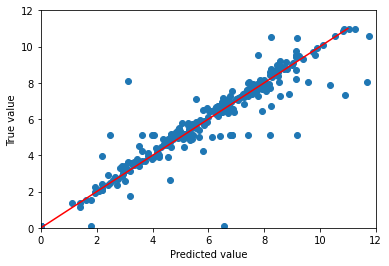

In [ ]:
# plot for number of likes prediction
from matplotlib import pyplot
pyplot.figure()
pyplot.scatter(y_train_like[3:200003:100],y_pred[3:200003:100])
pyplot.plot(range(12),range(12),'r')
pyplot.xlim(0, 12)
pyplot.ylim(0, 12)
pyplot.xlabel("Predicted value")
pyplot.ylabel("True value")

In [ ]:
# mean square error and r square for number of likes prediction
from sklearn.metrics import mean_squared_error, r2_score
print(mean_squared_error(y_train_like, y_pred, squared=False))
print(r2_score(y_train_like, y_pred))

0.8149268006911704
0.9004037448211337


In [ ]:
import pickle
model_path="gdrive/My Drive/ESP-ImageSet/"
model=pickle.load( open(model_path+"deep_learning_share_model.sav", "rb") )

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [ ]:
import pickle
data_dir = 'gdrive/My Drive/ESP-ImageSet/'
X_image_train = pickle.load( open(data_dir+"deep_learning_X_image_train_input.p", "rb") )
X_text_train = pickle.load( open(data_dir+"deep_learning_X_text_train_input.p", "rb") )
y_train_like = pickle.load( open(data_dir+"deep_learning_y_train_like_output.p", "rb") )
y_train_comment = pickle.load( open(data_dir+"deep_learning_y_train_comment_output.p", "rb") )
y_train_share = pickle.load( open(data_dir+"deep_learning_y_train_share_output.p", "rb") )
#y_pred=model.predict([X_image_train, X_text_train])

In [ ]:
y_pred=model.predict([X_image_train, X_text_train])

In [ ]:
# mean square error and r square for number of shares prediction
from sklearn.metrics import mean_squared_error, r2_score
print(mean_squared_error(y_train_share, y_pred, squared=False))
print(r2_score(y_train_share, y_pred))

1.9187081004005297
0.478933187794062


Text(0, 0.5, 'True value')

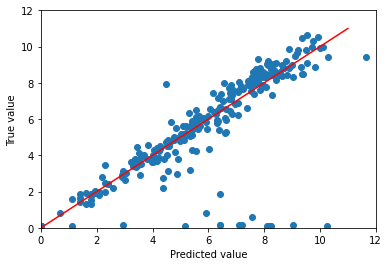

In [ ]:
# plot number of shares prediction
from matplotlib import pyplot
pyplot.figure()
pyplot.scatter(y_train_share[3:200003:100],y_pred[3:200003:100])
pyplot.plot(range(12),range(12),'r')
pyplot.xlim(0, 12)
pyplot.ylim(0, 12)
pyplot.xlabel("Predicted value")
pyplot.ylabel("True value")